# Irminger Sea 11 Wind Comparison

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

# Import typing for function docstrings
import typing
from typing import Union, Tuple, List
import numpy.typing as npt

### Load the ship met data
I wrote a module of functions (the underway.py file) to parse and load the underway data. So we'll import those functions and use them to get the data into a nice dataset

In [2]:
from underway import *

In [3]:
ship_dir = "/home/jovyan/wind_comparisons/data/Irminger_Sea-11/"
ship_met_files = sorted(["/".join((ship_dir, x)) for x in os.listdir(ship_dir) if x.endswith('.csv')])
met_headers = ["/".join((ship_dir, x)) for x in os.listdir(ship_dir) if 'MET_X' in x]
par_header = "/".join((ship_dir, 'MET_PAR.txt'))
rad_header = "/".join((ship_dir, 'MET_RAD.txt'))

# Parse the underway data
underway = parse_ship_met_data(ship_met_files, ATTRS, met_headers=met_headers, par_header=par_header, rad_header=rad_header)
underway

/home/jovyan/wind_comparisons/scripts/underway.py:272: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(' NAN', np.nan).replace(' NODATA', np.nan)


<xarray.Dataset> Size: 3MB
Dimensions:                            (time: 10272)
Coordinates:
  * time                               (time) datetime64[ns] 82kB 2024-06-02T...
Data variables: (12/36)
    latitude                           (time) float64 82kB 41.52 41.52 ... 59.93
    longitude                          (time) float64 82kB -70.67 ... -39.36
    ship_speed                         (time) float64 82kB nan nan ... -0.04
    heading                            (time) float64 82kB 25.76 25.8 ... 110.0
    DPS_COG                            (time) float64 82kB 278.3 59.06 ... 103.8
    speed_over_ground                  (time) float64 82kB 0.02 0.01 ... 0.24
    ...                                 ...
    sea_surface_temperature            (time) float64 82kB 17.03 17.02 ... 6.845
    speed_of_sound                     (time) float64 82kB 1.473e+03 ... 1.47...
    depth12                            (time) float64 82kB nan nan ... nan nan
    depth35                            (time) float64 82kB nan nan ... nan nan
    em122                              (time) float64 82kB nan nan ... nan nan
    EM710                              (time) float64 82kB nan nan ... nan nan

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

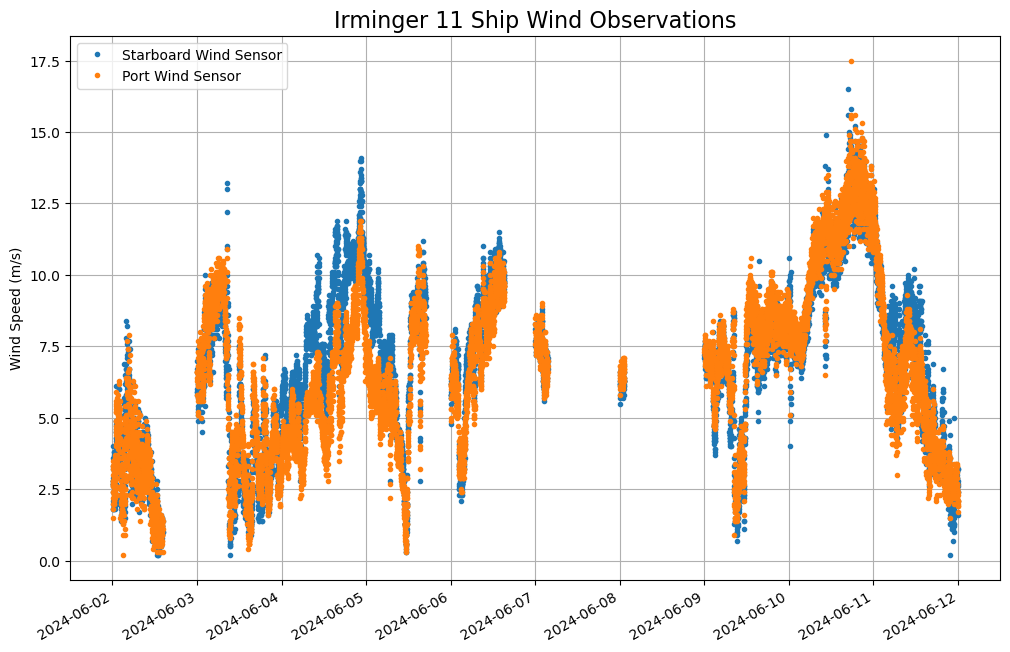

In [5]:
# Plot a timeseries of the ship observations
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(underway["time"], underway["wind_speed_starboard"], marker=".", linestyle="", label="Starboard Wind Sensor")
ax.plot(underway["time"], underway["wind_speed_port"], marker=".", linestyle="", label="Port Wind Sensor")
ax.legend()
ax.set_title('Irminger 11 Ship Wind Observations', fontsize=16)
ax.set_ylabel('Wind Speed (m/s)')
ax.grid()

fig.autofmt_xdate()

In [7]:
underway.to_netcdf("../data/Irminger_Sea-11_underway.nc", format="NETCDF4", engine="h5netcdf")

## Irminger Buoy Data

In [ ]:
from erddapy import ERDDAP

Next, we want to connect to the ERDDAP server which has the telemetered data. Since the data is not yet being ingested into the public-facing OOI Data Explorer, we're going to access the data via the OMS++ system. OMS is the internal operators dashboard which contains much of the same data. We will search for and download the data on the OMS++ erddap server.

In [ ]:
oms = ERDDAP(
    server="https://cgsn-dashboard.whoi.edu/erddap/",
    protocol="tabledap",
)

Now that we're connected to the ERDDAP server, we want to search for the available datasets

In [ ]:
search_url = oms.get_search_url(response="csv")
search = pd.read_csv(search_url)
datasets = search["Dataset ID"]
datasets

Wow. That is a lot of datasets that are availabe for download/access via OMS++. We need to figure out which one is for our data. We'll look for the array "GI01SUMO" and the instrument "METBK" to be in the dataset name/id

In [ ]:
for d in datasets:
    if "GI01SUMO" in d.upper() and "METBK" in d.upper():
        print(d)

We also want to find the FDCHP instrument (Direct Flux Covariance) which also measures wind speed using a three-axis sonic anemometer

In [ ]:
for d in datasets:
    if "GI01SUMO" in d.upper() and "FDCHP" in d.upper():
        print(d)

So the Irminger buoy has two datasets: METBK 1 and METBK 2. Additionally, during mooring turns, the _new_ buoy is deployed before the _old_ buoy is recovered. This means that there is a period of time when two buoys, and thus four wind sensors, were in the water. Combined with the ship observations, this makes for six datasets for comparison. So we want to query for the following Datasets:
* GI01SUMO-BUOY-METBK-01-1: Deployment 10 (D0010) & Deployment 11 (D0011)
* GI01SUMO-BUOY-METBK-02-1: Deployment 10 (D0010) & Deployment 11 (D0011)
* GI01SUMO-BUOY-FDCHP-01-1: Deployment 10 (D0010) & Deployment 11 (D0011)

If we just query the OMS++ ERDDAP server for a given dataset id (e.g. GI01SUMO-BUOY-METBK-01-1) that will provide us _all_ of the data for that dataset available from OMS++. However, we only want data for a given deployment number and for the times which overlap the ship observations. We can pass in constraints to the ERDDAP server to limit what data we get back. The constraints we want to use are:
* deploy_id=
* time>=
* time<=
where deploy_id is a given deployment (e.g. D0010) the times are the bounding start and end times for the data, passed in using the format "YYYY-mm-ddTHH:MM:SS".

First, get the time limits of the ship observations:

In [ ]:
startTime = underway.time.min()
stopTime = underway.time.max()
startTime, stopTime

Next, lets get the METBK-01-1 dataset for deployment 10:

In [ ]:
# Set the constraints
oms.dataset_id = "GI01SUMO-BUOY-METBK-02-1"
oms.constraints = {
    "deploy_id=": "D0011",
    "time>=": '2024-06-02T00:00:01',
    "time<=": '2024-06-12T00:00:01'
}

# Convert the data to a pandas dataframe indexed by time
d10_metbk1 = oms.to_pandas(index_col='time (UTC)', parse_dates=True)
d10_metbk1

In [ ]:
d10_metbk1.to_csv("../data/metbk2_deployment11.csv")

In [ ]:
# Now lets get the rest of the datasets
# Set the constraints
oms.dataset_id = "GI01SUMO-BUOY-FDCHP-01-1"
oms.constraints = {
    "deploy_id=": "D0010",
    "time>=": '2024-06-02T00:00:01',
    "time<=": '2024-06-12T00:00:01'
}

# Convert the data to a pandas dataframe indexed by time
d10_metbk1 = oms.to_pandas(index_col='time (UTC)', parse_dates=True)
d10_metbk1

In [ ]:
# Plot some comparison time series figures here
d10_metbk1.to_csv("../data/fdchp_deployment11.nc")

In [8]:
# Load the data
metbk1_d10 = pd.read_csv("../data/metbk1_deployment10.csv")
metbk1_d11 = pd.read_csv("../data/metbk1_deployment11.csv")
metbk2_d11 = pd.read_csv("../data/metbk2_deployment11.csv")
fdchp  = pd.read_csv("../data/fdchp_deployment11.csv")

---
### Adjust the data
One complicating factor in making an comparisons between the ship and buoy wind data is that the ship data is measured from the ship mast which, on the Armstrong, is at 17.9 m height. In comparison, the buoy MET wind sensors are mounted on the mast of the buoy. The buoy deck sits 45 cm above the water line, while the wind sensors and FDCHP are mounted 540 cm above the buoy deck. So we need to correct for the height differences between the sensors on the Armstrong and the buoys. We do this by defining a function based on the COARE (Coupled Ocean-Atmosphere Response Experiment) 3.5 flux algorithms.

In [9]:
# We first need to calculate the 10-meter wind speeds U10 and the friction-velocity u* (ustar)
def dragNC35(z: Union[int, float], U: npt.NDArray[float]) -> Tuple[npt.NDArray[float], npt.NDArray[float]]:
    """
    Calculate 10 meter winds and u* winds using COARE 3.5 algorithm
    
    Parameters
    ----------
    z: float
        The height of the wind sensor in meters
    U: float
        The measured wind speed by the wind sensor

    Returns
    -------
    U10: float
        The 10 meter winds
    Ustar: float
        The friction velocity
    """

    # Define constants
    wstr = 0.2/1.2
    ug = 0.2
    von = 0.4
    visc = 1.45E-5
    umax = 19
    a1 = 0.0017
    a2 = -0.005
    charnold = 0.011
    rnn = 1/9

    # Run the COARE 3.5 algorithm
    # Initialize values
    ut = np.sqrt(U*U + ug*ug)
    us = 0.035*ut
    charn=a1*ut + a2
    mask = (charn > umax)
    charn[mask] = a1*umax+a2
    # Iterate 10 times, updating with each successive pass
    i=0
    while i<10:
        z0 = visc/us*rnn + charn*us*us/9.8
        us = ut*von/np.log(z/z0)
        u10 = ut + us/von*np.log(10/z)
        # Update the charn variable
        mask = (u10 > umax)
        charn[mask] = a1*umax + a2
        charn[~mask] = a1*u10[~mask] + a2
        # Calculate ustar
        ustar = us
        # Calculate 10m winds
        U10 = ut + us/von*np.log(10/z)
        # Update counter
        i = i + 1

    return U10, ustar

# Next, we write a function which uses the u* values to adjust the heights
def adjust_height(wspd: npt.NDArray[float], ustar: npt.NDArray[float], z: Union[int, float], z0: Union[int, float]) -> npt.NDArray[float]:
    """
    Adjust the height of a wind sensor from height z to height z0
    
    Parameters
    ----------
    wspd: numpy.array[float]
        An array of observed wind speeds at height z
    ustar: numpy.array[float]
        An array of ustar values for the associated wspd at height
        z
    z: int | float
        Height at which the winds were observed in meters
    z0: int | float
        Height to adjust the observed wind speeds to in meters

    Returns
    -------
    adjusted: numpy.array[float]
        An array of the observed wind speeds adjusted from height z to height z0
    """

    correction = (ustar/0.4)*np.log(z0/z)
    adjusted = wspd + correction

    return adjusted

In [10]:
# Calculate the U10 and ustar 
U10, ustar = dragNC35(17.9, underway["wind_speed_starboard"].values)

# Add the ustar to the underway data
underway["friction_velocity_starboard"] = (["time"], ustar)
underway["friction_velocity_starboard"].attrs = {
    'standard_name': 'friction_velocity',
    'long_name': 'Friction Velocity - Starboard',
    'units': 'm s-1',
    'comment': ('Friction velocity is a reference wind velocity that relates the Reynold\'s stress with the density. It is '
                'applied to motion near the ground where the shearing stress is assumed to be independent of height and '
                'proportional to the square of the mean velocity.')
}

# Repeat for the port sensor

In [11]:
# Calculate the adjusted wind speed
wspd = underway["wind_speed_starboard"]
ustar = underway["friction_velocity_starboard"]
underway["adj_wind_speed_starboard"] = adjust_height(wspd, ustar, 17.9, 5.85)
underway["adj_wind_speed_starboard"]


<xarray.DataArray 'adj_wind_speed_starboard' (time: 10272)> Size: 82kB
array([1.64807681, 2.94080235, 2.5714212 , ..., 2.20196642, 2.94080235,
       2.94080235])
Coordinates:
  * time     (time) datetime64[ns] 82kB 2024-06-02T00:00:54.506000 ... 2024-0...

In [12]:
# Repeat for port sensor
# Calculate the U10 and ustar 
U10, ustar = dragNC35(17.9, underway["wind_speed_port"].values)

# Add the ustar to the underway data
underway["friction_velocity_port"] = (["time"], ustar)
underway["friction_velocity_port"].attrs = {
    'standard_name': 'friction_velocity',
    'long_name': 'Friction Velocity - Starboard',
    'units': 'm s-1',
    'comment': ('Friction velocity is a reference wind velocity that relates the Reynold\'s stress with the density. It is '
                'applied to motion near the ground where the shearing stress is assumed to be independent of height and '
                'proportional to the square of the mean velocity.')
}

# Calculate the adjusted wind speed
wspd = underway["wind_speed_port"]
ustar = underway["friction_velocity_port"]
underway["adj_wind_speed_port"] = adjust_height(wspd, ustar, 17.9, 5.85)
underway["adj_wind_speed_port"]

<xarray.DataArray 'adj_wind_speed_port' (time: 10272)> Size: 82kB
array([2.20196642, 2.5714212 , 2.47905569, ..., 1.92495065, 1.83264063,
       1.74034868])
Coordinates:
  * time     (time) datetime64[ns] 82kB 2024-06-02T00:00:54.506000 ... 2024-0...

Now we have data that are directly comparable to each other. I would recommend saving your different datasets as new datasets locally so you don't have to go through the different data access steps. Now we are ready to begin analysis!

---
## Comparison Data

In [13]:
# First, need to calculate the wind speed and wind direction from the northward and eastward wind directions

In [14]:
def wind_speed_and_direction(u: Union[int, float, npt.NDArray[float]], v: Union[int, float]) -> Union[int, float]:
    """Calculate the wind speed and direction from the vector wind components"""
    wspd = np.sqrt(u**2 + v**2)
    wdir = np.mod(180/np.pi*np.arctan2(u, v), 360)
    return wspd, wdir